# Summary of Imaging Analyses Results

In [1]:
# imports
import os
import polars as pl
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
import operator
from adjustText import adjust_text

sys.path.append("../../..")
from utils import *

In [2]:
BATCH_LIST_DICT = {
    # "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
    # "2024_02_06_Batch_8": "2024_02_Batch_7-8",
    # "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
    # "2024_12_09_Batch_12": "2024_12_Batch_11-12",
    "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
    "2025_01_28_Batch_14": "2025_01_Batch_13-14",
    # "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
    # "2025_03_17_Batch_16": "2025_03_Batch_15-16"
}

BIO_REP_BATCHES_DICT = {
    "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

METADATA_INPUT = "../../../../1_allele_collection/3_outputs"
FEAT_SETS = ["DNA", "Mito", "GFP", "AGP", "Morph"]
CLASS_RES_OUTDIR = "../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses"
INTEGRATIVE_INPUT = "../../../../3_integrated_assay_analyses/1_inputs/imaging"

In [36]:
clin_var_df = pl.read_csv(f"{METADATA_INPUT}/varchamp_alleles_with_pillar_annotations.tsv", 
                          separator="\t", infer_schema_length=1000000
).with_columns(
    pl.col("gene_variant").alias("gene_allele"),
)
clin_var_df.head()

symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,dualip_ref_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,mislocalization_ref_sequence_confirmation_class,gene_variant,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,gene_allele
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,…,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,str
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ASPA_Ala148Asp""","""Ala148Asp""",true,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ASPA_Ala148Asp""","""Ala148Asp""",true,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ASPA_Ala148Gly""","""Ala148Gly""",true,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""ASPA_Ala148Gly""","""Ala148Gly""",true,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,nul

In [37]:
# priority_col = ["orf_id", "mut_id", "symbol", "aa_change", "gene_allele", "gene_variant", "ensembl_gene_id", "clinvar_clnsig_clean", "gnomad_af", "StarStatus", "pillar_tested"]
clin_var_df = clin_var_df.with_columns( ## .select(priority_col).filter(~pl.col("mut_id").is_null())
    pl.col("mut_id").cast(pl.Int64).alias("mut_id"),
    pl.col("orf_id").cast(pl.Int64).alias("orf_id")
)

In [38]:
cell_count_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_cell-count_changes.csv").rename(
    {"U2OS_paired_t_stat": "U2OS_cc_t_stat", "U2OS_paired_t_pval": "U2OS_cc_t_pval", "Variant": "gene_allele"}
)
prot_abund_summary = pl.read_csv(f"{CLASS_RES_OUTDIR}/2.cell_count_abundance_change/2025_01_Batch_13-14/well-level_prot-abundance_changes.csv").rename(
    {"U2OS_paired_t_stat": "U2OS_abun_t_stat", "U2OS_paired_t_pval": "U2OS_abun_t_pval", "Variant": "gene_allele"}
)
auroc_summary_df = pl.read_csv(f"{CLASS_RES_OUTDIR}/3.classification_analyses/2025_01_Batch_13-14/imaging_analyses_classification_summary.csv")
auroc_summary_df

gene_allele,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,Gene
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""SDHD_Gly106Val""","""2025_01_Batch_13-14""",0.778163,0.834339,0.799601,0.858283,0.697296,0.755168,0.807092,0.769505,0.793184,0.672306,0.766665,0.820715,0.784553,0.825733,0.684801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""SDHD"""
"""SOS2_Val869Ile""","""2025_01_Batch_13-14""",0.660541,0.981839,0.996189,0.981104,0.698522,0.799511,0.987445,0.997277,0.993171,0.713993,0.730026,0.984642,0.996733,0.987137,0.706257,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,"""SOS2"""
"""RET_Thr338Ile""","""2025_01_Batch_13-14""",0.917492,0.710512,0.659498,0.59265,0.8981,0.920531,0.902788,0.843026,0.920583,0.829956,0.919012,0.80665,0.751262,0.756617,0.864028,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"""RET"""
"""CCM2_Arg389Trp""","""2025_01_Batch_13-14""",0.879888,0.891073,0.906692,0.907211,0.793835,0.680867,0.848538,0.898244,0.820994,0.59598,0.780377,0.869806,0.902468,0.864102,0.694907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""CCM2"""
"""SHOC2_Ser4Arg""","""2025_01_Batch_13-14""",0.917976,0.918094,0.87941,0.91422,0.866539,0.675518,0.808099,0.742499,0.738974,0.640452,0.796747,0.863096,0.810955,0.826597,0.753496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""SHOC2"""
"""F9_Val257Ile""","""2025_01_Batch_13-14""",0.635507,0.65873,0.665284,0.687625,0.537441,0.535348,0.612348,0.655996,0.728649,0.433697,0.585427,0.635539,0.66064,0.708137,0.485569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""F9"""
"""RAD51D_Thr328Ile""","""2025_01_Batch_13-14""",0.743703,0.903129,0.976082,0.893506,0.763948,0.92969,0.948831,0.96934,0.957925,0.912051,0.836696,0.92598,0.972711,0.925716,0.838,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""RAD51D"""
"""CCM2_Ser408Arg""","""2025_01_Batch_13-14""",0.961143,0.920082,0.887009,0.897563,0.874833,0.892717,0.917361,0.84637,0.810417,0.859613,0.92693,0.918722,0.866689,0.85399,0.867223,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"""CCM2"""
"""CCM2_Ser330Phe""","""2025_01_Batch_13-14""",0.876421,0.888864,0.942451,0.927182,0.858974,0.817851,0.914391,0.966137,0.906203,0.799394,0.847136,0.901627,0.954294,0.916693,0.829184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""CCM2"""


In [39]:
auroc_summary_df.filter(pl.col("gene_allele").str.contains("RHO"))

gene_allele,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,Gene
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""RHO_Pro267Thr""","""2025_01_Batch_13-14""",0.851346,0.902517,0.99459,0.980275,0.917511,0.955634,0.971574,0.998483,0.994197,0.945688,0.90349,0.937045,0.996537,0.987236,0.931599,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,"""RHO"""
"""RHO_Cys110Tyr""","""2025_01_Batch_13-14""",0.872791,0.970932,0.999353,0.996078,0.979052,0.879082,0.987451,0.999749,0.997256,0.985505,0.875936,0.979191,0.999551,0.996667,0.982279,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,"""RHO"""
"""RHO_Arg135Trp""","""2025_01_Batch_13-14""",0.848451,0.97691,0.999578,0.997115,0.983037,0.828956,0.983734,0.999812,0.998267,0.989435,0.838703,0.980322,0.999695,0.997691,0.986236,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,"""RHO"""
"""RHO_Asp190Gly""","""2025_01_Batch_13-14""",0.783341,0.973871,0.999351,0.997668,0.973984,0.763643,0.979532,0.999559,0.998346,0.980202,0.773492,0.976701,0.999455,0.998007,0.977093,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,"""RHO"""


In [44]:
imaging_summary = cell_count_summary.join(
    prot_abund_summary,
    on=["Gene", "gene_allele"],
    how="full",
    coalesce=True
).join(
    auroc_summary_df,
    on=["Gene", "gene_allele"],
    how="full",
    coalesce=True
).with_columns(
    pl.lit(True).alias("image_assayed")
).join(
    clin_var_df,
    on=["gene_allele"],
    how="left"
)
imaging_summary.write_csv("../../../../3_integrated_assay_analyses/1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", separator="\t")

In [45]:
imaging_summary.filter(pl.col("gene_allele").str.contains("KRAS"))

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,symbol,ensembl_gene_id,orf_id,mut_id,…,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,str,str,i64,i64,…,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""KRAS""","""KRAS_Gly60Arg""",-2.525126,0.039513,5.200357,0.001253,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,"""KRAS""","""ENSG00000133703""",3084,214488,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""KRAS""","""KRAS_Gly60Arg""",-2.525126,0.039513,5.200357,0.001253,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,"""KRAS""",null,3084,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""KRAS""","""KRAS_Asp153Val""",-0.382208,0.713646,1.906273,0.098295,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,"""KRAS""","""ENSG00000133703""",3084,214494,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""KRAS""","""KRAS_Asp153Val""",-0.382208,0.713646,1.906273,0.098295,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,"""KRAS""",null,3084,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""KRAS""","""KRAS_Phe156Ile""",-1.374346,0.211718,4.603768,0.002473,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,tr

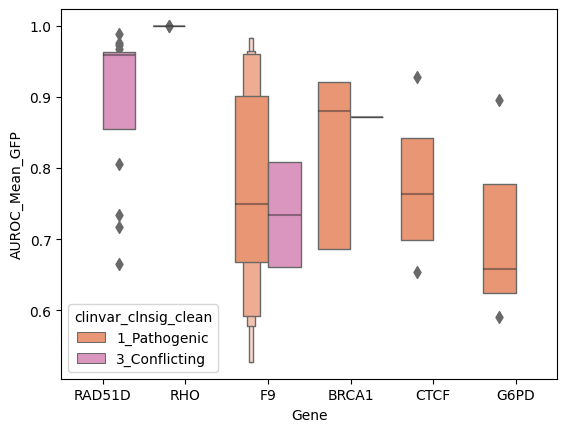

In [47]:
sns.boxenplot(
    data=imaging_summary.filter(pl.col("pillar_tested")).to_pandas(),
    x="Gene",
    y="AUROC_Mean_GFP",
    # ax=axes.flatten()[i-1],
    palette=palette_dict["clinvar_clnsig_clean"], 
    hue="clinvar_clnsig_clean", 
    hue_order=hue_order,
    dodge="auto"
)
plt.show()

In [49]:
# imaging_summary.filter(pl.col("pillar_tested")).unique("Gene")

<Figure size 640x480 with 0 Axes>

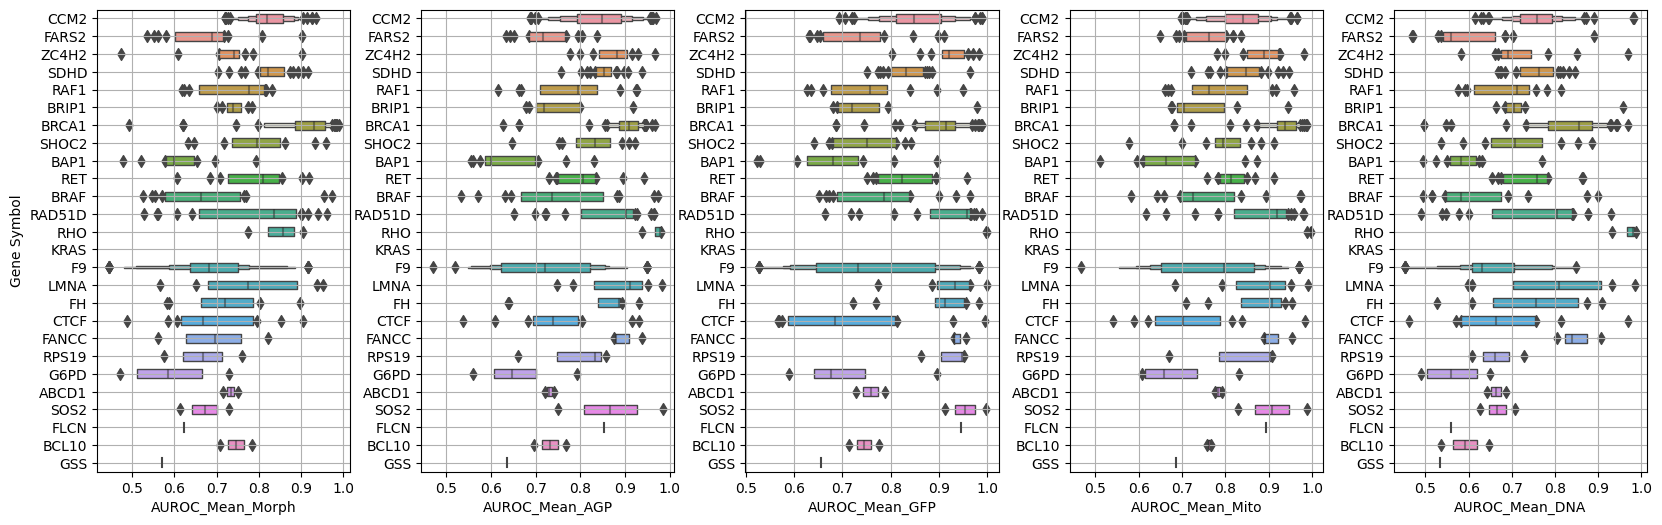

In [25]:
plt.clf()
fig, ax = plt.subplots(1,5,figsize=(20, 6))
auroc_cols = [col for col in imaging_summary.columns if col.startswith("AUROC_Mean")]
for i, col in enumerate(auroc_cols):
    sns.boxenplot(data=imaging_summary.to_pandas(), 
                x=col, y="Gene", ax=ax[i], width=.5)
    # ax.set_xlabel("AUROC_Mean_GFP")
    ax[i].set_ylabel("")
    ax[i].grid()
ax[0].set_ylabel("Gene Symbol")
plt.subplots_adjust(wspace=.28)
plt.show()

gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 1 name,Interval 1 MaveDB class,AUROC_Mean_Morph
str,str,str,str,str,f64
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""Functional""","""Normal""",0.620069
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""Functional""","""Normal""",0.930671
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""Functional""","""Normal""",0.881766
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""Functional""","""Normal""",0.940271
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""Functional""","""Normal""",0.927047
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""Functional""","""Normal""",0.967725
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""Functional""","""Normal""",0.955578


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_Morph
str,str,str,str,str,f64
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.620069
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.967725
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.881766
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.927047
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.940271
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.930671
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.955578


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 3 name,Interval 3 MaveDB class,AUROC_Mean_Morph
str,str,str,str,str,f64
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.881766
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.955578
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""Intermediate""","""Not specified""",0.967725
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""Intermediate""","""Not specified""",0.940271
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.930671
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.620069
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""Intermediate""","""Not specified""",0.927047


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 1 name,Interval 1 MaveDB class,AUROC_Mean_AGP
str,str,str,str,str,f64
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""Functional""","""Normal""",0.903605
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""Functional""","""Normal""",0.901028
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""Functional""","""Normal""",0.930422
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""Functional""","""Normal""",0.918189
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""Functional""","""Normal""",0.865099
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""Functional""","""Normal""",0.663015
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""Functional""","""Normal""",0.928097


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_AGP
str,str,str,str,str,f64
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.928097
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.903605
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.918189
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.930422
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.865099
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.901028
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.663015


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 3 name,Interval 3 MaveDB class,AUROC_Mean_AGP
str,str,str,str,str,f64
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""Intermediate""","""Not specified""",0.930422
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.865099
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""Intermediate""","""Not specified""",0.928097
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.663015
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""Intermediate""","""Not specified""",0.903605
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.918189
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.901028


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 1 name,Interval 1 MaveDB class,AUROC_Mean_GFP
str,str,str,str,str,f64
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""Functional""","""Normal""",0.872209
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""Functional""","""Normal""",0.899079
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""Functional""","""Normal""",0.685848
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""Functional""","""Normal""",0.86021
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""Functional""","""Normal""",0.9335
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""Functional""","""Normal""",0.919332
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""Functional""","""Normal""",0.921312


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_GFP
str,str,str,str,str,f64
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.872209
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.919332
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.9335
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.921312
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.86021
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.899079
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.685848


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 3 name,Interval 3 MaveDB class,AUROC_Mean_GFP
str,str,str,str,str,f64
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""Intermediate""","""Not specified""",0.872209
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.86021
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""Intermediate""","""Not specified""",0.9335
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.921312
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.685848
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.899079
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""Intermediate""","""Not specified""",0.919332


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 1 name,Interval 1 MaveDB class,AUROC_Mean_Mito
str,str,str,str,str,f64
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""Functional""","""Normal""",0.940053
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""Functional""","""Normal""",0.919005
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""Functional""","""Normal""",0.969432
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""Functional""","""Normal""",0.967036
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""Functional""","""Normal""",0.956083
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""Functional""","""Normal""",0.681612
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""Functional""","""Normal""",0.928145


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_Mito
str,str,str,str,str,f64
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.956083
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.967036
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.928145
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.681612
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.940053
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.969432
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.919005


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 3 name,Interval 3 MaveDB class,AUROC_Mean_Mito
str,str,str,str,str,f64
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""Intermediate""","""Not specified""",0.956083
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.928145
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.967036
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.681612
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""Intermediate""","""Not specified""",0.919005
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""Intermediate""","""Not specified""",0.969432
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.940053


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 1 name,Interval 1 MaveDB class,AUROC_Mean_DNA
str,str,str,str,str,f64
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""Functional""","""Normal""",0.851588
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""Functional""","""Normal""",0.857109
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""Functional""","""Normal""",0.866001
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""Functional""","""Normal""",0.497403
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""Functional""","""Normal""",0.887589
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""Functional""","""Normal""",0.733135
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""Functional""","""Normal""",0.886519


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,AUROC_Mean_DNA
str,str,str,str,str,f64
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""LOF""","""Abnormal""",0.886519
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""LOF""","""Abnormal""",0.887589
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""LOF""","""Abnormal""",0.497403
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""LOF""","""Abnormal""",0.866001
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""LOF""","""Abnormal""",0.733135
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""LOF""","""Abnormal""",0.857109
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""LOF""","""Abnormal""",0.851588


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 3 name,Interval 3 MaveDB class,AUROC_Mean_DNA
str,str,str,str,str,f64
"""BRCA1_Thr581Ile""","""BRCA1_Thr1685Ile""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.857109
"""BRCA1_Gly602Ala""","""BRCA1_Gly1706Ala""","""2_Benign""","""Intermediate""","""Not specified""",0.851588
"""BRCA1_Phe558Ser""","""BRCA1_Phe1662Ser""","""2_Benign""","""Intermediate""","""Not specified""",0.887589
"""BRCA1_Val632Ala""","""BRCA1_Val1736Ala""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.866001
"""BRCA1_Phe591Leu""","""BRCA1_Phe1695Ile""","""3_Conflicting""","""Intermediate""","""Not specified""",0.886519
"""BRCA1_Leu660Pro""","""BRCA1_Leu1764Pro""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.497403
"""BRCA1_Gly666Val""","""BRCA1_Gly1770Val""","""1_Pathogenic""","""Intermediate""","""Not specified""",0.733135


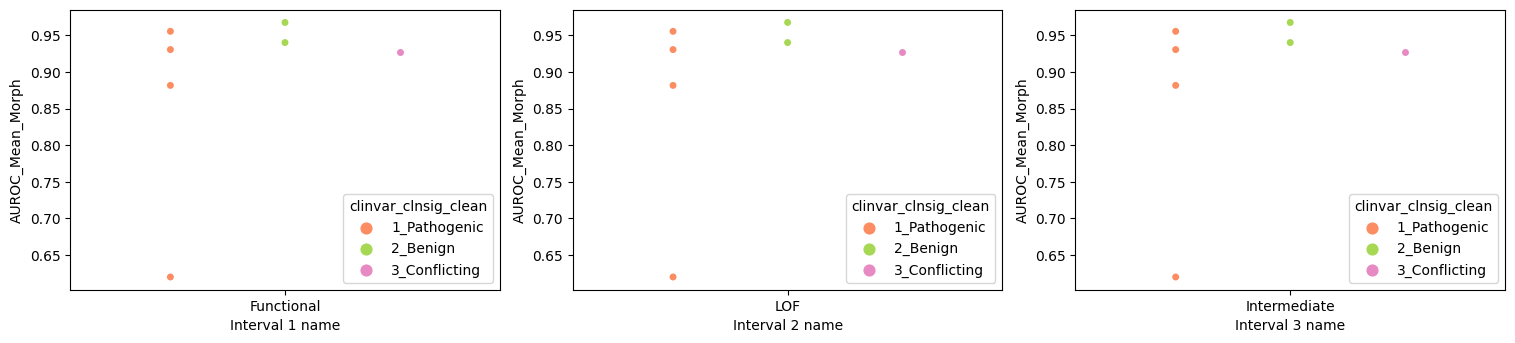

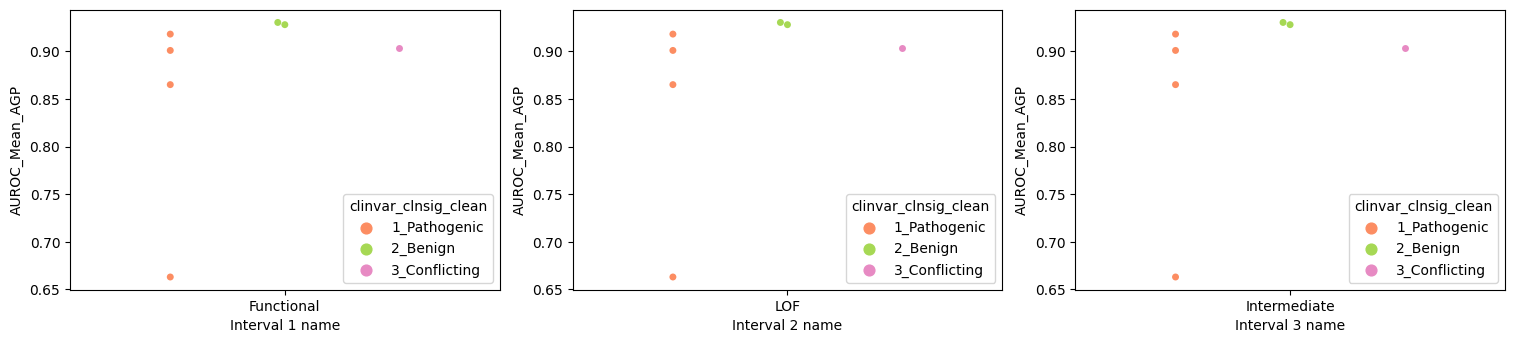

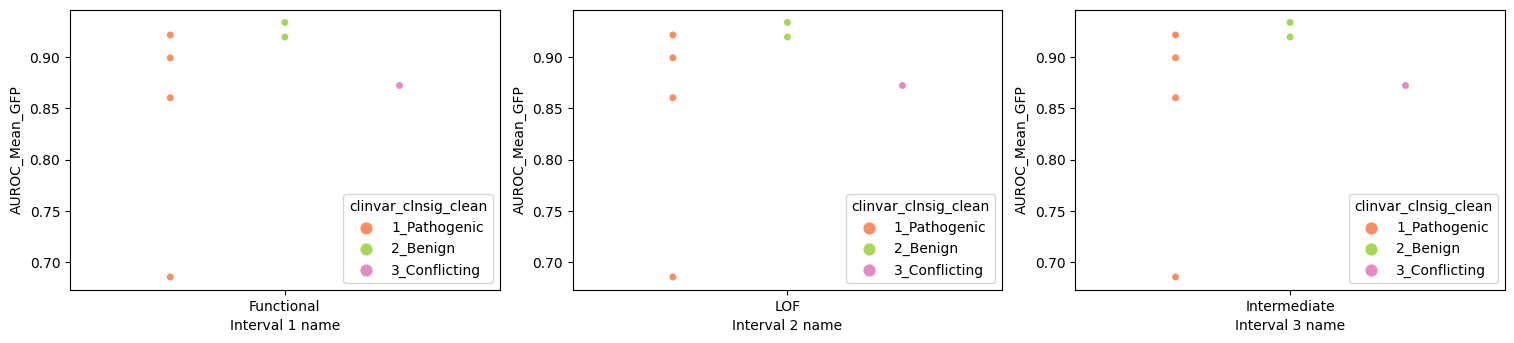

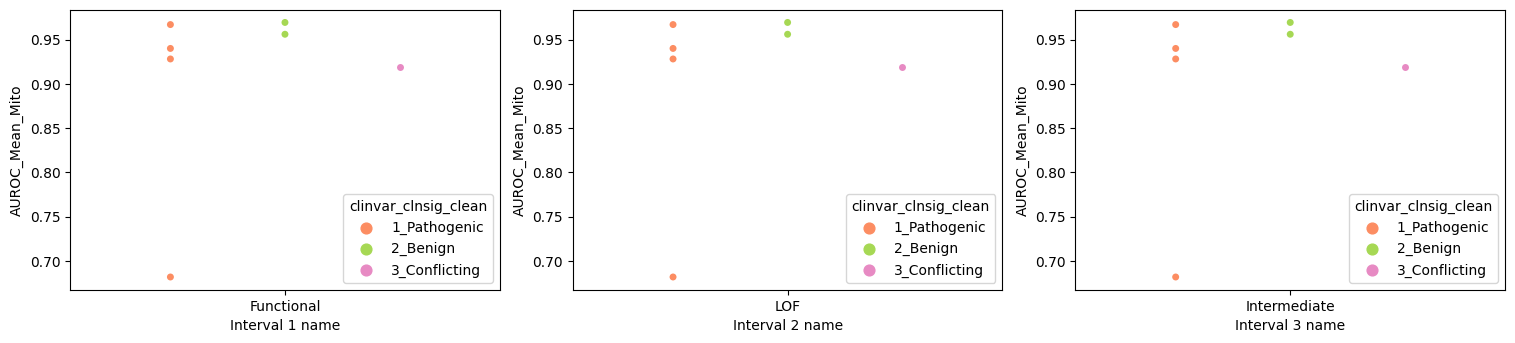

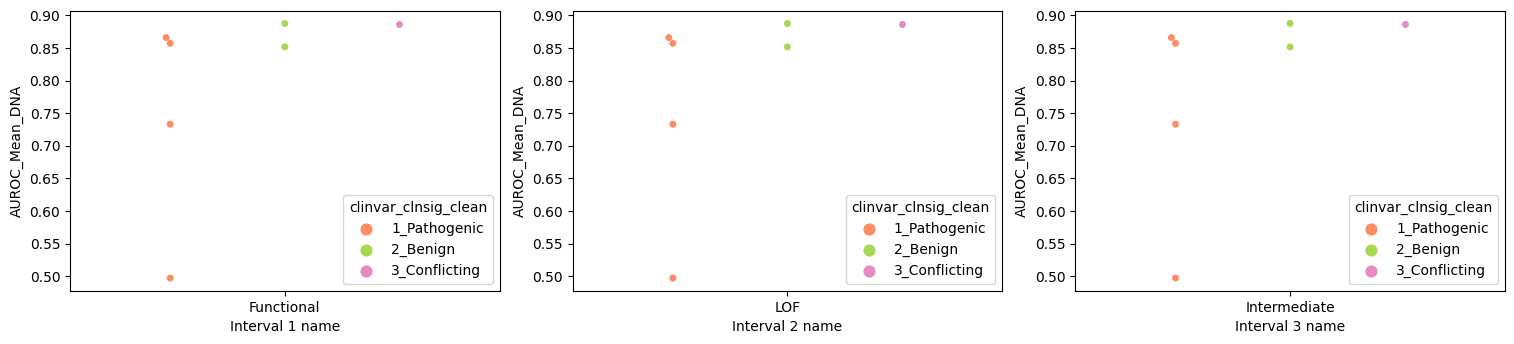

In [50]:
func_scores = imaging_summary.filter(pl.col("pillar_tested"))
pl.Config.set_tbl_rows(25)  # Show all rows

for x, col in enumerate(auroc_cols):
    fig, axes = plt.subplots(2, 4, figsize=(25,8))
    for i in range(1,7):
        int_name = f"Interval {i} name"
        mavedb_name = f"Interval {i} MaveDB class"
        func_mave = func_scores.drop_nulls(pl.col(mavedb_name))
        if func_mave.shape[0] > 0:
            # display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name, "zscore_log2"])
            # fig, ax = plt.subplots(1,2,figsize=(15,6))
            hue_order = sorted(func_mave.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
            sns.swarmplot(
                data=func_mave.unique(subset="gene_variant").to_pandas(),
                x=int_name,
                y=col,
                ax=axes.flatten()[i-1],
                palette=palette_dict["clinvar_clnsig_clean"], 
                hue="clinvar_clnsig_clean", 
                hue_order=hue_order,
                dodge="auto",
                # width=.6,
            )
            display(func_mave.unique(subset="gene_variant").select(
                ["gene_variant", "gene_variant_pp","clinvar_clnsig_clean", int_name, mavedb_name, col]
            ))
            # axes.flatten()[i-1].axhline(func_mave["dualipa_threshold"].to_numpy()[0], color="tomato", linestyle="--")
            # sns.boxenplot(
            #     data=func_mave.unique(subset="gene_variant").to_pandas(),
            #     x=mavedb_name,
            #     y="zscore_log2",
            #     ax=ax[1],
            #     palette=palette_dict["clinvar_clnsig_clean"],
            #     hue="clinvar_clnsig_clean", 
            #     hue_order=hue_order,
            #     dodge=True
            # )
        else:
            fig.delaxes(axes.flatten()[i-1])

    fig.delaxes(axes.flatten()[6])
    fig.delaxes(axes.flatten()[7])
    plt.subplots_adjust(wspace=0.17)
    
plt.show()